# CSCE 623 Homework Assignment 5
## Student Name: Marvin Newlin
## Date: 21 May 19


In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

In [2]:
# Load and Preprocess the data

## STEP 0. 
(instructor provided) Load the ILSR_hitters.csv dataset.  Remove the observations for whom the salary information is unknown, and then 

In [45]:
# STEP 0  - Load data & convert categorical features - instructor provided code

state = 1  #random seed
Hitters = pd.read_csv('ISLR_Hitters.csv',index_col=0)
Hitters = Hitters.dropna(how='any')
Hitters = Hitters.reset_index()

Hitters = Hitters.drop(['index'],axis=1)
Hitters['League'] = Hitters['League'].map({'A': 0, 'N': 1})
Hitters['Division'] = Hitters['Division'].map({'E': 0, 'W': 1})
Hitters = Hitters.drop(['NewLeague'],axis=1)


## STEP 1.  
Log-transform the salaries (salaries listed are in $1000’s).  Note that you will need to account for this log-transformation when presenting your results (transform your precisions, loss, MSE, improvement, etc. back to real salary dollars when possible)

In [60]:
#STEP1 

# helper functions for transformation
# the transformed salary should work better for model fitting
def salary_transform(salary):
    transformed_salary = salary
    transformed_salary = np.log10(transformed_salary) # Takes the log base 10 of each element
    return transformed_salary

# the untransformed salary is needed for test set performance reporting and residuals analysis
def salary_untransform(transformed_salary):
    salary = np.power(10, transformed_salary)  # raises 10 to the power of each element to undo the log
    
    return salary

#transform the salary
print(Hitters['Salary'][:3])
Hitters['Salary'] = salary_transform(Hitters.Salary)
print(Hitters['Salary'][:3])
# note that this block will give an error until the salary component is filled out

0    2.631036
1    2.631784
2    2.634677
Name: Salary, dtype: float64
0    0.420127
1    0.420250
2    0.420727
Name: Salary, dtype: float64


# STEP 2.
(Code Provided) Using sklearn.model_selection.train_test_split with random_state = 1,  create a “non-test” set consisting of 200 observations and a test set consisting of the remaining observations.  Sequester the test set until  the performance reporting steps (9-11).

In [47]:
Hitters_nonTest, Hitters_test = train_test_split(Hitters, train_size = 200, random_state=1)


# Explore the data & make hypotheses

## STEP 3.
Explore the data.  Use plots and discuss relationships between available features and Salary.  Consider using the seaborn package to facilitate your exploration – for example, make a heatmap plot of the correlation between each pair of features to help you decide which pairs of features to explore further with pairs plots or scatterplots.  Make at least one hypothesis about which features will be useful in predicting salary.  

In [48]:
display(Hitters_nonTest.head())
display(Hitters_nonTest.describe())

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary
228,528,122,1,67,45,51,4,1716,403,12,211,146,155,0,1,209,372,17,2.544068
29,379,106,10,38,60,30,14,6207,1906,146,859,803,571,1,1,72,170,24,2.929419
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,2.676694
177,381,110,9,61,45,32,7,3015,834,40,451,249,168,1,0,228,7,5,2.903090
122,309,94,5,37,32,26,13,4618,1330,57,616,522,436,1,0,161,3,3,2.778151


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary
count,200.000000,200.00000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,395.420000,105.71500,11.25000,53.895000,50.740000,40.915000,7.565000,2749.530000,749.845000,71.520000,373.160000,343.935000,270.195000,0.50500,0.515000,283.025000,114.260000,8.280000,2.578092
std,144.037661,44.52715,8.34781,25.252772,25.346293,22.446761,4.939409,2364.387587,674.196362,84.187811,341.374674,336.346466,272.990045,0.50123,0.501029,283.374434,141.788619,6.511806,0.379870
min,20.000000,1.00000,0.00000,0.000000,0.000000,0.000000,1.000000,41.000000,9.000000,0.000000,6.000000,7.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.845098
25%,282.500000,70.00000,5.00000,32.750000,30.000000,22.000000,4.000000,824.500000,205.250000,15.750000,102.000000,93.750000,74.750000,0.00000,0.000000,114.750000,7.000000,3.000000,2.298281
50%,396.500000,102.00000,9.00000,50.000000,46.000000,36.000000,6.000000,2089.500000,543.500000,40.000000,275.500000,239.500000,177.000000,1.00000,1.000000,211.000000,44.000000,7.000000,2.628389
75%,511.250000,137.25000,17.00000,72.000000,70.250000,58.250000,11.000000,3926.500000,1068.750000,93.000000,507.000000,452.250000,351.750000,1.00000,1.000000,310.750000,179.000000,12.250000,2.875061
max,687.000000,238.00000,40.00000,117.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1.00000,1.000000,1377.000000,492.000000,32.000000,3.390935


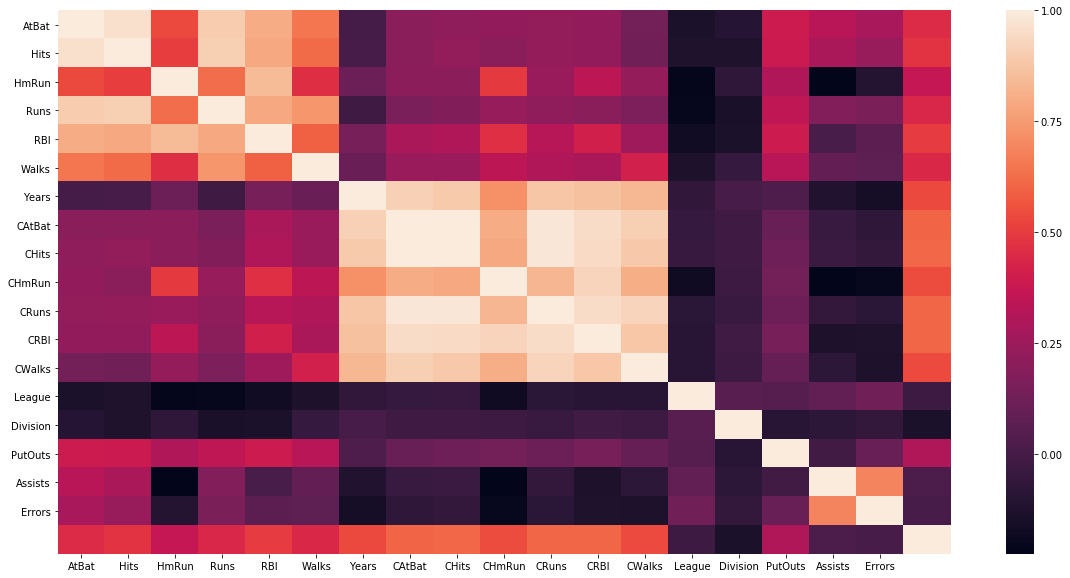

In [62]:
fig = plt.figure(figsize=(20,10))
Hitters_nonTest_noSal = Hitters_nonTest.iloc[:, :len(Hitters_nonTest.columns)-1]

g = sns.heatmap(Hitters_nonTest.corr(), xticklabels=Hitters_nonTest_noSal.columns,
        yticklabels=Hitters_nonTest_noSal.columns)

plt.show()

In [ ]:
#Hitters_sub = Hitters_nonTest.pivot("AtBat", "Hits", "Salary")
#g = sns.heatmap(Hitters_sub, cmap="YlGnBu")

## STEP 4.
Using what you saw during your exploration, make a prediction about your expectations on the performance of the random forest with respect to hyper parameter settings maximum tree depth (max_depth), and the number of features to consider at each split (max_features).  Explain your rationale for your performance expectations.

# Train the model & Tune Hyperparameters using Cross-Validation

## STEP 5.
Using sklearn k-fold split (sklearn.model_selection.KFold), write code to set up a k-fold cross-validation with the goal of choosing the best hyperparameters for a random forest model (sklearn.ensemble.RandomForestRegressor)     Select and provide rationale for your choice for n_splits based on amount of data you have available in the non-test set.  Your goal is to determine the best combination of two parameters: maximum tree depth (max_depth), and the number of features to consider at each split (max_features).   The hyperparameter  max_depth of the trees should include integer values from 1 to 20, and your exploration over max_features should include values from 1 to p (all features).  You can decide whether to fix the number of trees (n_estimators) or include it as a third hyperparameter to explore (it should start with at least 100 but you may want to explore higher values if you will tune this hyperparameter with cross-validation) – then explain whether you are selecting a specific value or tuning this value with cross validation.   Since you will use a cross-validation wrapper to tune hyperparameters, set oob_score to False in the initialization call to RandomForestRegressor.   For each tuple of (max_depth, max_features), compute and collect the mean k-fold cross-validation MSE using predict().  

In [60]:
"""
    This function calculates the KFold Cross Validation MSE on a randomForest regressor
    Returns: MSE
"""
def calc_rf_cv_mse(kf, X, y, num_estimators, max_depth, max_features, seed):
    rf = RFR(n_estimators=num_estimators, max_depth=d, max_features=p, random_state=seed, oob_score=False)
    avg_mse = []
    for train, val in kf.split(X, y):
        rf.fit(X[train], y[train]) # Fit on train folds
        y_pred = rf.predict(X[val])# Predicted values on val fold
        mse = MSE(y[val], y_pred)  # Calc MSE
        avg_mse.append(mse)        # Append to list 
    avg_mse = np.array(avg_mse)    
    return avg_mse.mean()

In [61]:
# Use K = 5 here. We have 200 observations in nontest so 40 points per fold
kfold = KFold(n_splits=5, random_state=1)
rf_mse_list = []
max_feat_list = []
max_depth_list = []
y = np.array(Hitters_nonTest['Salary'])
X = np.array(Hitters_nonTest.loc[:,:'Salary'])

for d in range(1,21):
    for p in range(1,len(Hitters_nonTest.columns)+1):
        mse = calc_rf_cv_mse(kfold, X, y, 100, d, p, 1)
        rf_mse_list.append(mse)
        max_feat_list.append(p)
        max_depth_list.append(d)

In [62]:
print(rf_mse_list)        

[0.0702415790038199, 0.05242596732059762, 0.048665289504386734, 0.0465201164055325, 0.0443691393180943, 0.042884480299292774, 0.04172862800752437, 0.040652550814491664, 0.03996305757717748, 0.038431334456769994, 0.037768507318102475, 0.036552177586560826, 0.03598070760906451, 0.03584994183968269, 0.03563607230974569, 0.035552194544974734, 0.03595767440516723, 0.03611848970678831, 0.036953180091750616, 0.05064407072950524, 0.036036335295793864, 0.031810266706029926, 0.02782464963471794, 0.02739429151265335, 0.025254453727879184, 0.021364609093346816, 0.020544863051885454, 0.018222955341542536, 0.016380409203356774, 0.016002065671084913, 0.013005171730008164, 0.012309812280433024, 0.01167040602408961, 0.010076071864282674, 0.008548640945569876, 0.008063870963864107, 0.007728981800953455, 0.007570433036895273, 0.040414949943854014, 0.02920669725320301, 0.02510044361060832, 0.023311729741633765, 0.020835604807765702, 0.017883047612958624, 0.014124256840685074, 0.013161323887687213, 0.01176

## STEP 6. 
Provide convincing visual evidence of the validation MSE performance (from step 5) as a function of max_features and max_depth (and n_estimators if you chose to tune it).    A good way to do this is to plot the error on a graph as a function of the two dimensions max_depth and max_features.  Contour maps work here.

C:\Users\Marvin\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


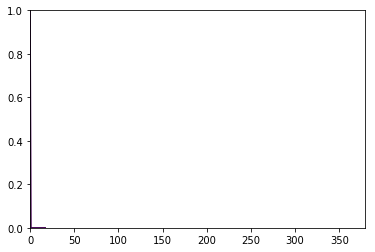

In [73]:
ax = plt.contour([max_depth_list, max_feat_list], rf_mse_list)

## STEP 7.
Using code, determine, display visually, and report the values of these parameters with the lowest MSE.  Discuss the minimum value of max_features in light of the random forest recommendation for max_features: sqrt(p) or p/3.  Did your result agree with the general guidance on max features?

## STEP 8.
Using the best values of  max_features and max_depth found with MSE, fit a new RandomForestRegressor model trained on all the non-test data.

# Reporting performance on the Test Set

## STEP 9.
Using code, determine and report the quality of the model for predicting salary on the sequestered test set.  Don’t forget to handle the log transformation you did in data preprocessing – your performance values should be based on real dollars (not log-transformed dollars).  

## STEP 10.
Develop a scatterplot of the regression residuals:  The figure’s x axis expresses the true dollar amount of salary, the figure’s y axis represents the prediction error (positive values mean overprediction, negative values mean underprediction, and y=0 would mean correct prediction).   Discuss these residuals.  Are they evenly distributed about y=0 through the range of possible true salaries?  Do you see any patterns which would suggest true salaries for which prediction would be poor?

## STEP 11.
Using the model, report on variable importance - which variables appear to be the most important predictors in the model?  Using the sklearn feature_importance_ attribute of the best fitted model, provide numerical and visual evidence to support your answer (make sure to sort your outputs by feature importance).